## The New York Times Covid-19 Database

The New York Times Covid-19 Database is 
a county-level database of confirmed cases and deaths, 
compiled from state and local governments and health departments across the United States.
The initial release of the database was on Thursday, March 26, 2020, and it is updated daily. 

These data have fueled many articles and graphics by The Times; these are updated regularly at
[https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html). 
The Times has created many visualizations that are effective communications of important information about the pandemic. 

The data are publically available via GitHub: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).  In this illustration we will only use
the data aggregated at the state level. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
covid_table = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
covid_table = covid_table.drop('fips', axis=1)
covid_table.tail(20)

,date,state,cases,deaths
38290,2022-01-25,North Dakota,214506,2125
38291,2022-01-25,Northern Mariana Islands,4344,22
38292,2022-01-25,Ohio,2520112,32489
38293,2022-01-25,Oklahoma,922873,11873
38294,2022-01-25,Oregon,597172,5994
38295,2022-01-25,Pennsylvania,2593360,39749
38296,2022-01-25,Puerto Rico,478221,3731
38297,2022-01-25,Rhode Island,334581,3263
38298,2022-01-25,South Carolina,1265710,15108
38299,2022-01-25,South Dakota,221372,2609


### Process the recent data

Here is some code that creates a Table with the recent Covid-19 statistics for a given state. Just pass in the name of the state as a string.


In [3]:
merged_data = covid_table.drop('state', axis=1)
merged_data = merged_data.groupby('date').sum()
merged_data.tail(20)

,cases,deaths
date,,
2022-01-06,58505177,832953
2022-01-07,59405224,835637
2022-01-08,59851464,836327
2022-01-09,60166922,836728
2022-01-10,61600899,838412
2022-01-11,62370827,841092
2022-01-12,63251101,843823
2022-01-13,64120516,846110
2022-01-14,65053765,849101


In [4]:
new_cases = np.diff(merged_data['cases'])

# compute 7-day average
avg_cases = np.zeros(7)
for i in np.arange(7, len(new_cases)):
    avg_cases = np.append(avg_cases, np.mean(new_cases[(i-6):i+1]))

dates = np.array(merged_data['cases'].index)[1:]
data = np.array([new_cases, avg_cases]).T
cvd19 = pd.DataFrame(data, columns = ['new cases', '7-day avg'], index=dates)
cvd19.tail(10)

,new cases,7-day avg
2022-01-16,337884.0,806850.571429
2022-01-17,712051.0,703718.285714
2022-01-18,1178403.0,762071.857143
2022-01-19,851784.0,758001.857143
2022-01-20,748484.0,740726.000000
2022-01-21,825052.0,725269.285714
2022-01-22,337388.0,713006.571429
2022-01-23,199744.0,693272.285714
2022-01-24,1029906.0,738680.142857
2022-01-25,512947.0,643615.000000


In [5]:
cvd19.describe()

,new cases,7-day avg
count,7.350000e+02,735.000000
mean,9.824576e+04,95828.470943
std,1.474254e+05,129049.372988
min,-2.399900e+04,0.000000
25%,2.683250e+04,28616.428571
50%,5.495200e+04,61687.000000
75%,1.223535e+05,119694.714286
max,1.433977e+06,806934.428571


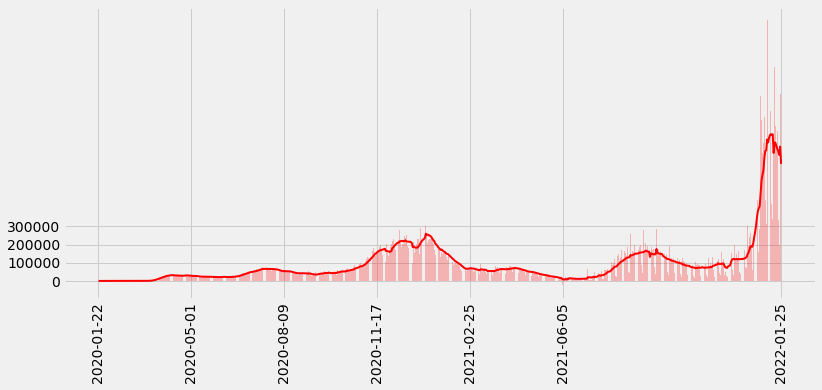

In [6]:
plt.figure(figsize=(12,5))
plt.bar(cvd19.index, cvd19['new cases'], color='red', alpha=.25)
plt.plot(cvd19.index, cvd19['7-day avg'], color='red', linewidth=2)
plt.xlabel('')
_ = plt.xticks(cvd19.index[[0, 100, 200, 300, 400, 500, len(dates)-1]], rotation=90)
_ = plt.yticks(np.linspace(0, 300000, 4))

Compare this to the graph here: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).


Let's now fit a linear regression to the recent data. First we filter to take everything after June 15.


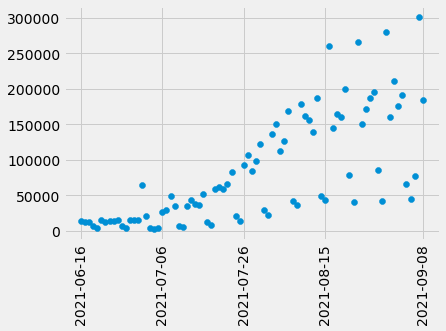

In [7]:
recent = cvd19[(cvd19.index > '2021-06-15') & (cvd19.index < '2021-09-09')]
y = recent['new cases']
dates = recent.index
plt.scatter(dates, y)
_ = plt.xticks(dates[[0, 20, 40, 60, len(dates)-1]], rotation=90)

Next we fit the "Ordinary Least Squares" regression using the `statsmodels.api` package.

In [8]:
import statsmodels.api as sm
x = np.arange(len(y))
X = sm.add_constant(x)
model = sm.OLS(y,X)
result = model.fit()
beta = [result.params.const, result.params.x1]

Finally, plot the results

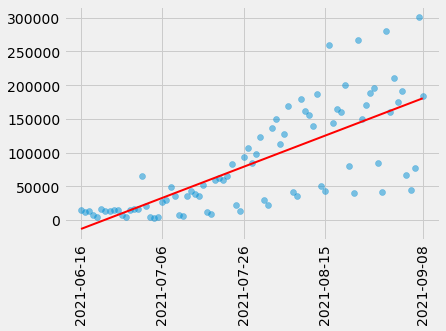

In [9]:
plt.scatter(dates, y, alpha=.5)
_ = plt.xticks(dates[[0, 20, 40, 60, len(dates)-1]], rotation=90)
_ = plt.plot(x, beta[0] + beta[1]*x, color='red', linewidth=2)

How would you describe the fit to the data? Can you filter out the low points (weekends?) and refit the model?